In [70]:
#Load helper packages
library(readr)
library(dplyr)
library(ggplot2)
options(warn=-1) # supresses warnings

In [71]:
#load in the first timeframe's data - in this case, Obama era counts
first <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/r/data/obama_count.csv", col_names = TRUE) 
#load in the second timeframe's data - in this case, Trump era counts
second <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/r/data/trump_count.csv", col_names = TRUE) 

#convert missing values (999) due to WM error to NAs
first[first==999] <- NA
second[second==999] <- NA

#load in a CSV that has the list of terms - this is for formatting outputs
terms<-read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/r/data/terms.csv", col_names = FALSE) 
terms<-tolower(terms)

#load in a CSV that has a list of the URLs, organizations, etc. 
urls <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/r/data/counted_urls.csv") 
#slashes removed means trailing slashes - those at the end of some urls - have been removed

#this does matrix math to calculate, for each page and term, the change (positive, negative, or zero) in usage
combined<-second-first 

Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  `url - o` = col_character(),
  `shortened url - o` = col_character(),
  `captured url - 0` = col_character(),
  `url - t` = col_character(),
  `shortened url - t` = col_character(),
  `final captured url - t` = col_character(),
  domain = col_character(),
  org = col_character()
)


In [73]:
### REQUIRED PROCESSING
## Handle duplicated URLs - find their "index"....
duplicates<-which(duplicated(urls$`url - o`) | duplicated(urls$`url - o`, fromLast = TRUE)) #url duplicates
duplicates.short<-which(duplicated(urls$`shortened url - o`) | duplicated(urls$`shortened url - o`, fromLast = TRUE))#shortened url duplicates
duplicates<-c(duplicates, duplicates.short)
duplicates<-unique(duplicates)

#....and then filter away
first<-first[-c(duplicates),]
second<-second[-c(duplicates),]
combined<-combined[-c(duplicates),]
urls<-urls[-c(duplicates),]

## Handle pages we don't want or can't process (e.g. Jan 2017 snapshots, blogs, Spanish-language pages)
pages.snapshots<-grep('snapshot', urls$`url - o`)
pages.edu<-grep('edu/', urls$`url - o`)
pages.news<-grep('news', urls$`url - o`)
pages.blog<-grep('blog', urls$`url - o`)
pages.News<-grep('News', urls$`url - o`)
pages.espanol<-grep('espanol', urls$`url - o`)

#Relevant to depth analysis
pages.length<-sapply(gregexpr("/", urls$`url - o`), length) # gets the number of slashes in each url (a proxy for importance/relevance)
pages.length<-which(pages.length > 6) # remove pages greater than 6 slashes. Arbitrary default.
# URLs > 4 3-4 http://www.epa.gov/theme/ http://www.epa.gov/theme http://www.epa.gov/ 
# URLs NOT 5 or NOT 6 5-6  http://www.epa.gov/theme/subtheme/page http://www.epa.gov/theme/subtheme/page/ http://www.epa.gov/theme/subtheme
# URLs 7 < 7 http://www.epa.gov/theme/subtheme/page/subpage http://www.epa.gov/theme/subtheme/page/subpage/subsubpage
# default is > 6
# for page depth analysis > 4 gets "2 or less". Gets rid of urls with 5 or more slashes. 
# for page depth analysis < = 4 gets "3 or more". Gets rid of urls with 4 or fewer.

dump<-c(pages.snapshots,pages.edu, pages.news,pages.blog, pages.News, pages.espanol, pages.length)
dump<-unique(dump)

first<-first[-c(dump),]
second<-second[-c(dump),]
combined<-combined[-c(dump),]
urls<-urls[-c(dump),]

##compare only on snapshots available in both timeframes
snaps<-which(!is.na(urls$`captured url - 0`) & !is.na(urls$`final captured url - t`))
first<-first[c(snaps),]
second<-second[c(snaps),]
combined<-combined[c(snaps),]
urls<-urls[c(snaps),]

##compare only on available counts (disregard NAs/999s)
nas<-which(is.na(first[,1])|is.na(second[,1]))
first<-first[-c(nas),]
second<-second[-c(nas),]
combined<-combined[-c(nas),]
urls<-urls[-c(nas),]

In [74]:
#### DEBUG
## Verify obama and trump urls match
errors=0
for (i in 1:nrow(urls)) {
  if (tolower(urls$`shortened url - o`[i]) != tolower(urls$`shortened url - t`[i])){
    errors<-errors+1
    print(i)
  }
}
errors

[1] 0

In [75]:
#SEE THE DATA
#combined.url is only the urls that aren't NA after combined/first. In other words, we exclude 0/0 (0 obama, 0 change) 
#How many pages was the term on in at least one of the timeframes...??
pc<-which(is.na(combined/first)) #Exclude 0->0 change
combined.full<-cbind(urls[c(1,3,6,8)], combined) 
combined.full<-combined.full[-c(pc),]
combined.full

,url - o,captured url - 0,final captured url - t,org,adaptation,agency mission,air quality,anthropogenic,benefits,brownfield,⋯,sensible regulations,state,storms,sustainability,toxic,transparency,unconventional gas,unconventional oil,water quality,wildfires
19,https://www3.epa.gov/climatechange/basics/,http://web.archive.org/web/20160624192336id_/https://www3.epa.gov/climatechange/basics/,http://web.archive.org/web/20180606054704id_/https://www.epa.gov/climatechange/basics/,EPA,-2,0,0,0,-1,0,⋯,0,-3,0,0,0,0,0,0,0,0
20,https://www3.epa.gov/climatechange/EPAactivities.html,http://web.archive.org/web/20160224232419id_/https://www3.epa.gov/climatechange/EPAactivities.html,http://web.archive.org/web/20180101223413id_/https://www3.epa.gov/climatechange/EPAactivities.html,EPA,-2,0,0,0,-3,0,⋯,0,-5,0,-1,0,0,0,0,0,0
21,http://www3.epa.gov/climatechange/climate-change-waste/index.html,http://web.archive.org/web/20151227221552id_/http://www3.epa.gov/climatechange/climate-change-waste/index.html,http://web.archive.org/web/20180101223416id_/https://www3.epa.gov/climatechange/climate-change-waste/index.html,EPA,-2,0,0,0,-1,0,⋯,0,-3,0,0,0,0,0,0,0,0
22,https://www3.epa.gov/climatechange/impacts/midwest.html,http://web.archive.org/web/20160227220855id_/https://www3.epa.gov/climatechange/impacts/midwest.html,http://web.archive.org/web/20180101223418id_/https://www3.epa.gov/climatechange/impacts/midwest.html,EPA,-2,0,-2,0,-2,0,⋯,0,-2,-1,0,-1,0,0,0,-2,-1
23,https://www3.epa.gov/climatechange/impacts/coasts.html,http://web.archive.org/web/20160227222145id_/https://www3.epa.gov/climatechange/impacts/coasts.html,http://web.archive.org/web/20180101223420id_/https://www3.epa.gov/climatechange/impacts/coasts.html,EPA,-7,0,0,0,-2,0,⋯,0,-2,-5,0,0,0,0,0,0,0
24,https://www3.epa.gov/climatechange/wycd/road.html,http://web.archive.org/web/20160227221250id_/https://www3.epa.gov/climatechange/wycd/road.html,http://web.archive.org/web/20180101223422id_/https://www3.epa.gov/climatechange/wycd/road.html,EPA,-2,0,0,0,-1,0,⋯,0,-2,0,0,0,0,0,0,0,0
26,https://www3.epa.gov/climatechange/wycd/office.html,http://web.archive.org/web/20160227221308id_/https://www3.epa.gov/climatechange/wycd/office.html,http://web.archive.org/web/20180101223426id_/https://www3.epa.gov/climatechange/wycd/office.html,EPA,-2,0,0,0,-2,0,⋯,0,-2,0,0,0,0,0,0,0,0
27,https://www3.epa.gov/climatechange/impacts/southeast.html,http://web.archive.org/web/20160227220909id_/https://www3.epa.gov/climatechange/impacts/southeast.html,http://web.archive.org/web/20180101223429id_/https://www3.epa.gov/climatechange/impacts/southeast.html,EPA,-3,0,-2,0,-1,0,⋯,0,-5,0,0,0,0,0,0,0,-2
28,https://www3.epa.gov/climatechange/impacts/agriculture.html,http://web.archive.org/web/20160227222204id_/https://www3.epa.gov/climatechange/impacts/agriculture.html,http://web.archive.org/web/20180101223431id_/https://www3.epa.gov/climatechange/impacts/agriculture.html,EPA,-6,0,0,0,-3,0,⋯,0,-2,0,-1,0,0,0,0,0,0
29,https://www3.epa.gov/climatechange/impacts/alaska.html,http://web.archive.org/web/20160227220936id_/https://www3.epa.gov/climatechange/impacts/alaska.html,http://web.archive.org/web/20180101223433id_/https://www3.epa.gov/climatechange/impacts/alaska.html,EPA,-2,0,0,0,-2,0,⋯,0,-8,0,0,0,0,0,0,0,-3


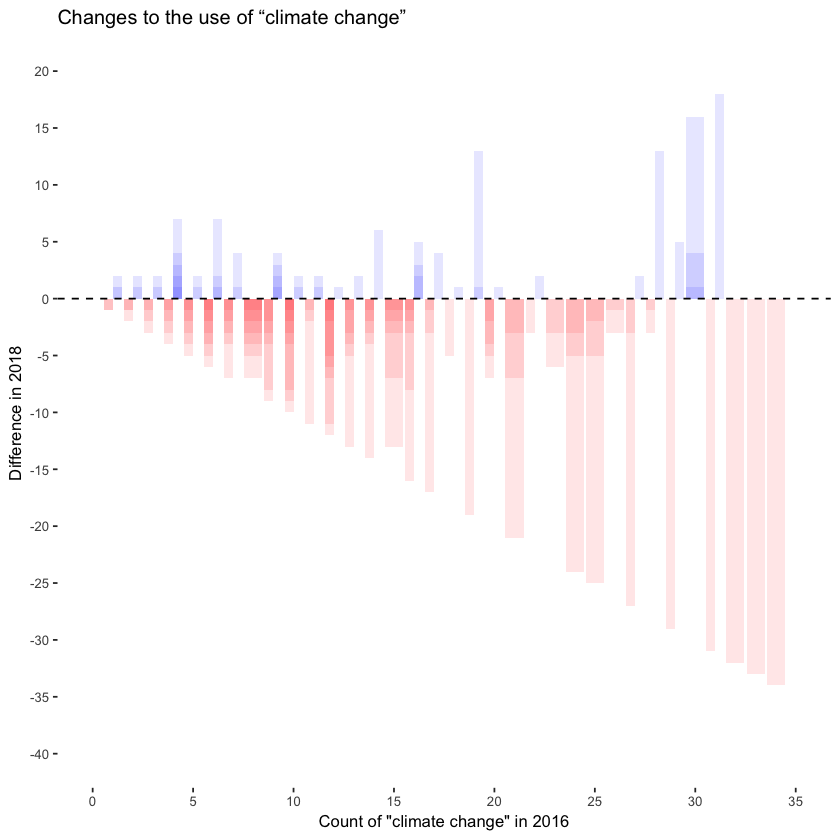

In [76]:
##### FIGURE 4
# This could be done in a loop to compare multiple terms, but for our purposes, we'll look at "climate change"
i=9 # "Climate Change"

df<-data.frame(first[,i], second[,i]) # filter to only the Climate Change column, putting both Obama and Trump data in the same frame
colnames(df)<-c("obama", "trump") 
change<-which(df$obama != 0 | df$trump != 0) #REMOVE ZEROS - we don't want to plot pages that didn't change
df<-df[c(change),]

df$change <- df$trump-df$obama # Calculate a new column, the change between 2016 and 2018
# count of unique count pairings by URLs. (1,2 | 1,4 | 3,1 | etc.) How many of each change 1->2, 1->4, 3->1 are there?
df.unique<-df %>% group_by(obama, change)%>%mutate(chg = sum(change), count=n()) 
df.unique<-unique(df.unique)

pal <- c("red", "blue") # pallette for increases and decreases

# Create the plot
p <- ggplot(df.unique, aes(obama, change, alpha=count, fill=change>0)) +
    geom_bar(stat='identity', position='dodge') +
    scale_fill_manual(values=pal) +
    labs(title = 'Changes to the use of “climate change”', x='Count of "climate change" in 2016', y='Difference in 2018')+
    theme(text=element_text(size=10), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            plot.background=element_rect(fill='white'), panel.background = element_rect(fill='white'), 
            legend.position="none", axis.line.x = element_line(colour = "black", size=0)) +
    scale_y_continuous(limits=c(-40,20), breaks=seq(-100, 80, 5)) +
    scale_x_continuous(limits=c(0,35), breaks=seq(0, 150, 5)) + 
    geom_hline(yintercept=0, linetype="dashed", color = "black")
p

In [77]:
##### FIGURE 5
# Again, this could be done in a loop to compare multiple terms, but for our purposes, we'll look at just "climate change"
# and resilience
i=9 #"Climate Change"
j=43 #"Resilience"

col<-first[c(i,j)] #from the first timeframe, the term count
tcol<-second[c(i,j)] #from the second teimframe, the term count

urlsDump<-urls # a temporary variable for our URLs
orgsDump<-data.frame(urls$org) # a temporary variable for our URLs (by agency)

#shed zeros - We won't count pages if both terms weren't used on same page
zeros<-which(col[,1]==0 & col[,2]==0)
col<-col[-c(zeros),]
tcol<-tcol[-c(zeros),] #here we are saying that we will eliminate second timeframe urls if in the first time the urls did not have both terms used
urlsDump<-urlsDump[-c(zeros),1]
orgsDump<-orgsDump[-c(zeros),1]

combo<-cbind(urlsDump, col, tcol, orgsDump)
colnames(combo)<-c("url", "o_CC", "o_R", "t_CC", "t_R", "orgs") 

# Now subset data to prepare for small multiples
#NOTE: BOTH TERMS HAVE TO CHANGE....i.e. no flat lines.
NE <- which(combo[,2]-combo[,4]<0 & combo[,3]-combo[,5] <0)
SE <- which(combo[,2]-combo[,4]<0 & combo[,3]-combo[,5] >0)
SW <- which(combo[,2]-combo[,4]>0 & combo[,3]-combo[,5] >0)
NW <- which(combo[,2]-combo[,4]>0 & combo[,3]-combo[,5] <0)
#E<-which(combo[,2]-combo[,4]<0 & combo[,3]-combo[,5] == 0) 
#N<-which(combo[,2]-combo[,4]==0 & combo[,3]-combo[,5] < 0) 
#S<-which(combo[,2]-combo[,4]==0 & combo[,3]-combo[,5] > 0) 

directions<-list(NE,SE,SW,NW)

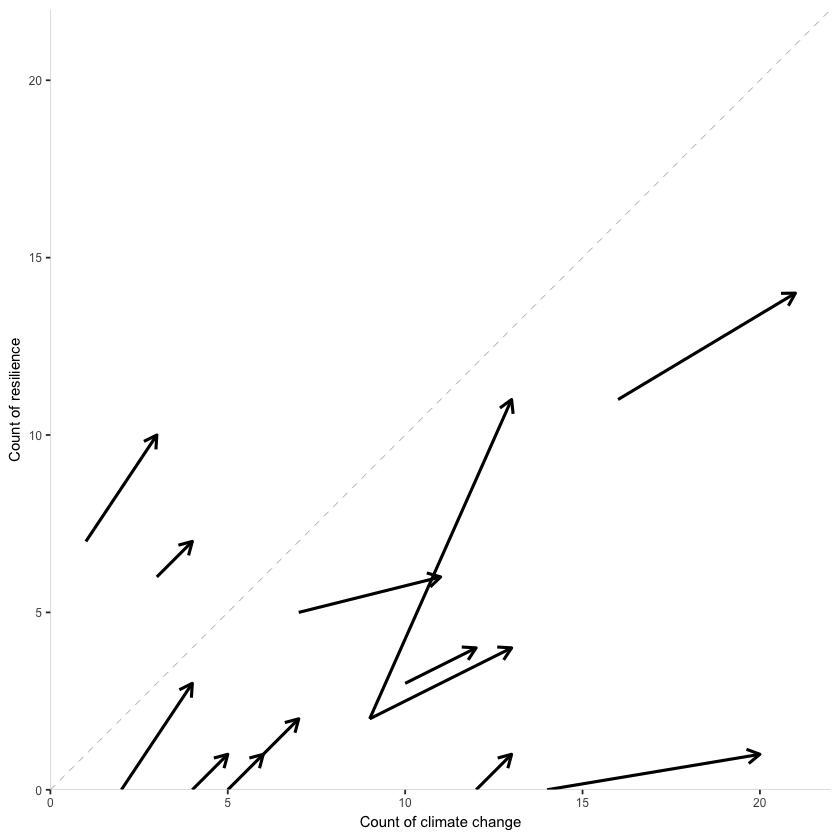

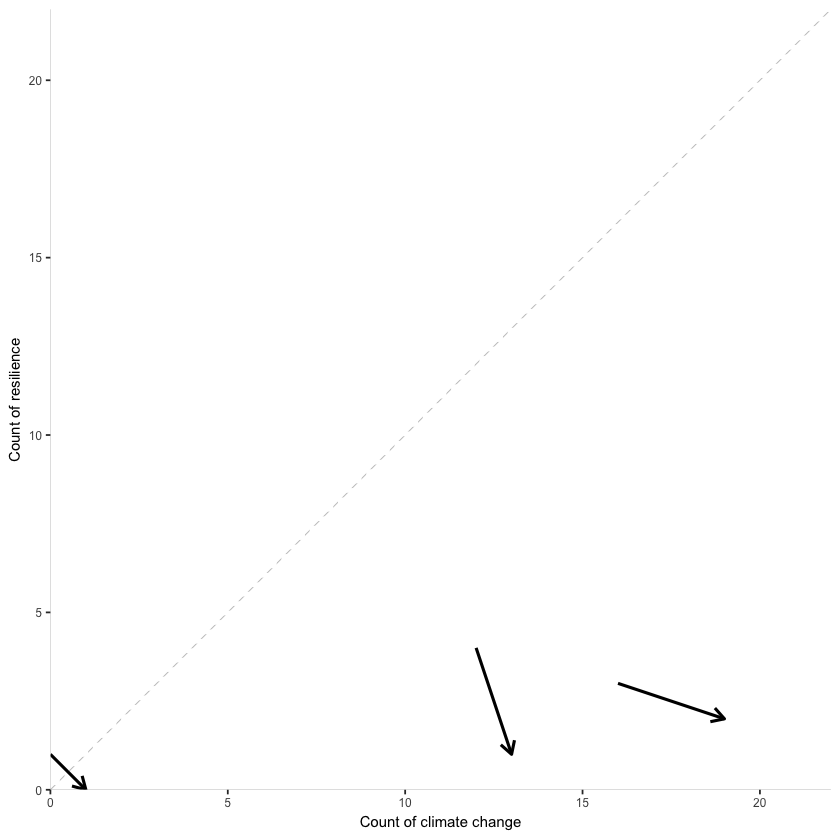

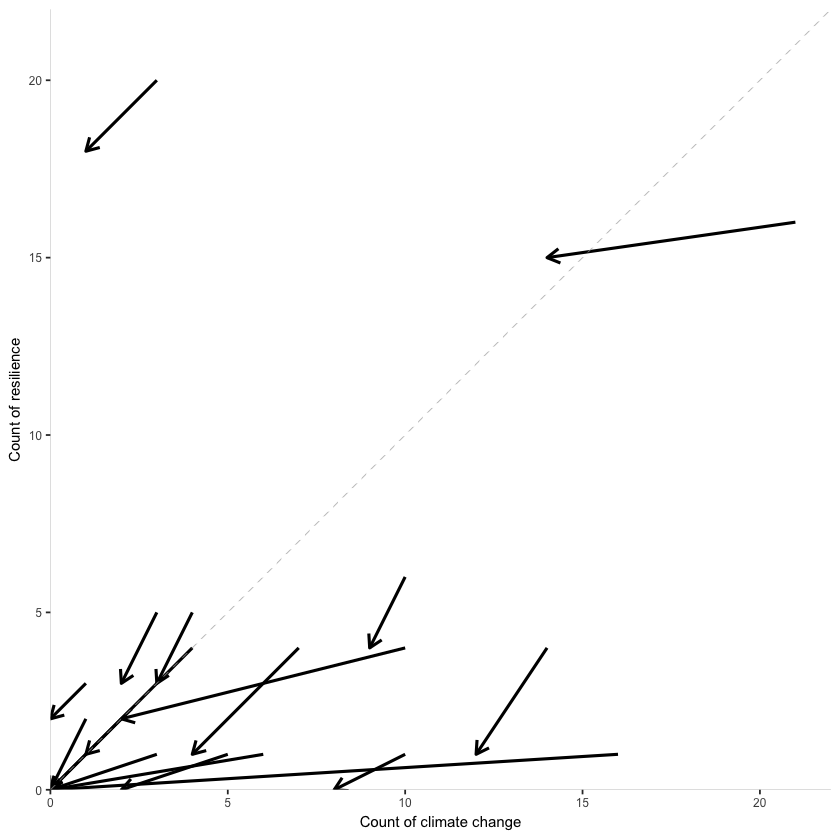

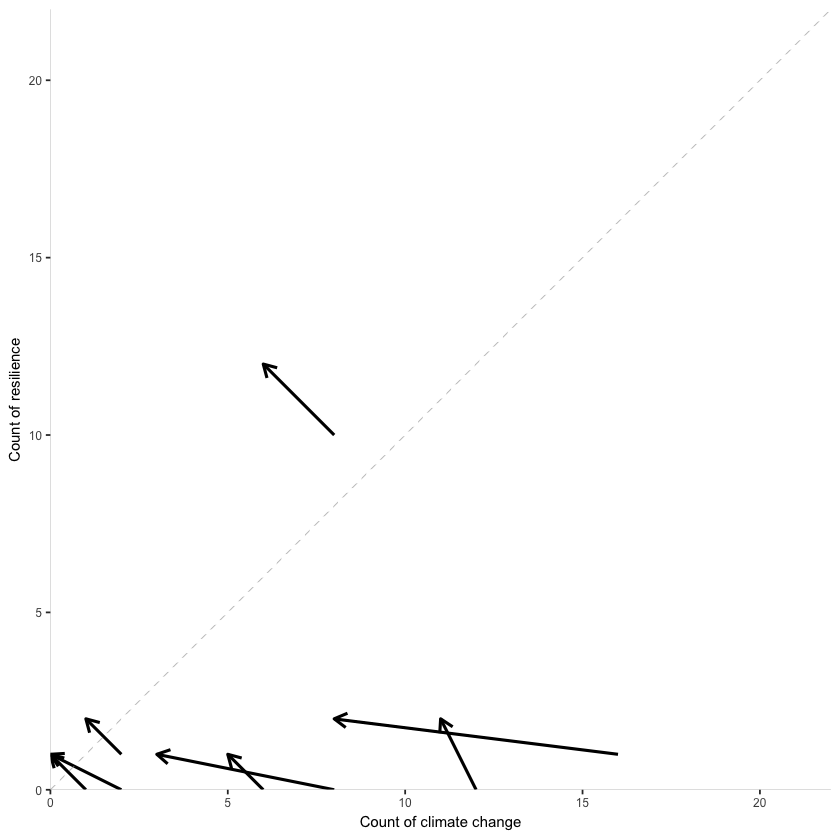

In [78]:
#FIGURE 5 - SMALL MULTIPLES
for (d in directions){
    
    combo<-cbind(urlsDump, col, tcol, orgsDump)
    colnames(combo)<-c("url", "o_CC", "o_R", "t_CC", "t_R", "orgs") 

    combo<-combo[c(d),] #Focus on the current direction
    
    combo<-combo[,c(2:5)] # get rid of unnecessary columns (URL, agency, etc.)
    c<-combo %>% group_by(o_CC, o_R, t_CC, t_R) %>%mutate(count = n())
    c<-unique(c)
    
    # Draw arrows
    p<-ggplot(c,aes(x = o_CC,y = o_R))+
    geom_point(aes(x = o_CC,y = o_R), size=0, color="white") + 
    geom_point(aes(x = t_CC,y = t_R), size=0, color="white") +
    scale_y_continuous(limits=c(0,22), expand = c(0,0)) +
    scale_x_continuous(limits=c(0,22),expand = c(0,0)) + 
    labs(x="Count of climate change", y="Count of resilience")+
    theme(aspect.ratio=1)+ 
    theme(text=element_text(size=9), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.background = element_blank(), legend.position="none", 
            axis.line = element_line(colour = "grey68", size=.1)) +
    geom_segment(aes(x = o_CC,y = o_R,xend = t_CC,yend = t_R, size=3), color="black", arrow=arrow(angle = 30, length = unit(0.12, "inches"), ends = "last", type = "open")) + 
    geom_abline(intercept=0, slope=1, colour="grey68", linetype=2, size=.2) + scale_size(range = c(.1, 1.2),guide=FALSE)  
    
    print(p)
}

,url,obama wm,trump wm,org,before,after,diff
4,https://www3.epa.gov/climatechange/,http://web.archive.org/web/20160621202353id_/https://www3.epa.gov/climatechange/,http://web.archive.org/web/20180105103404id_/https://epa.gov/climatechange/,EPA,27,0,-27
19,https://www3.epa.gov/climatechange/basics/,http://web.archive.org/web/20160624192336id_/https://www3.epa.gov/climatechange/basics/,http://web.archive.org/web/20180606054704id_/https://www.epa.gov/climatechange/basics/,EPA,33,0,-33
20,https://www3.epa.gov/climatechange/EPAactivities.html,http://web.archive.org/web/20160224232419id_/https://www3.epa.gov/climatechange/EPAactivities.html,http://web.archive.org/web/20180101223413id_/https://www3.epa.gov/climatechange/EPAactivities.html,EPA,21,0,-21
21,http://www3.epa.gov/climatechange/climate-change-waste/index.html,http://web.archive.org/web/20151227221552id_/http://www3.epa.gov/climatechange/climate-change-waste/index.html,http://web.archive.org/web/20180101223416id_/https://www3.epa.gov/climatechange/climate-change-waste/index.html,EPA,13,0,-13
22,https://www3.epa.gov/climatechange/impacts/midwest.html,http://web.archive.org/web/20160227220855id_/https://www3.epa.gov/climatechange/impacts/midwest.html,http://web.archive.org/web/20180101223418id_/https://www3.epa.gov/climatechange/impacts/midwest.html,EPA,25,0,-25
23,https://www3.epa.gov/climatechange/impacts/coasts.html,http://web.archive.org/web/20160227222145id_/https://www3.epa.gov/climatechange/impacts/coasts.html,http://web.archive.org/web/20180101223420id_/https://www3.epa.gov/climatechange/impacts/coasts.html,EPA,34,0,-34
24,https://www3.epa.gov/climatechange/wycd/road.html,http://web.archive.org/web/20160227221250id_/https://www3.epa.gov/climatechange/wycd/road.html,http://web.archive.org/web/20180101223422id_/https://www3.epa.gov/climatechange/wycd/road.html,EPA,12,0,-12
26,https://www3.epa.gov/climatechange/wycd/office.html,http://web.archive.org/web/20160227221308id_/https://www3.epa.gov/climatechange/wycd/office.html,http://web.archive.org/web/20180101223426id_/https://www3.epa.gov/climatechange/wycd/office.html,EPA,12,0,-12
27,https://www3.epa.gov/climatechange/impacts/southeast.html,http://web.archive.org/web/20160227220909id_/https://www3.epa.gov/climatechange/impacts/southeast.html,http://web.archive.org/web/20180101223429id_/https://www3.epa.gov/climatechange/impacts/southeast.html,EPA,21,0,-21
28,https://www3.epa.gov/climatechange/impacts/agriculture.html,http://web.archive.org/web/20160227222204id_/https://www3.epa.gov/climatechange/impacts/agriculture.html,http://web.archive.org/web/20180101223431id_/https://www3.epa.gov/climatechange/impacts/agriculture.html,EPA,31,0,-31


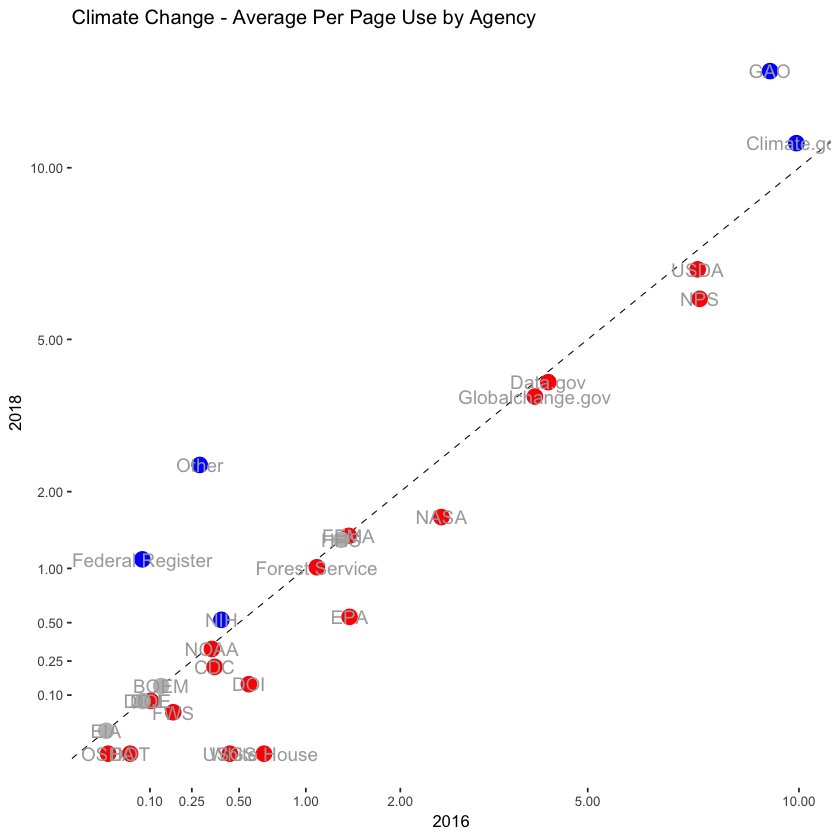

In [79]:
#### FIGURE 6

# This could be configured as a loop to go through each term but for our purposes here, we'll only look at "climate change"

i=9 # "Climate Change"

# Summarize all URLs by org (agency)
by.org<-urls%>% group_by(org) %>%summarise(num_of_pages=n()) 

#report by agency and count
pc<-which(is.na(combined[i]/first[i])) 
combined.url<-cbind(urls[c(1,3,6,8)], first[i], second[i], combined[i]) 
combined.url<-combined.url[-c(pc),]
colnames(combined.url)<-c("url", "obama wm", "trump wm", "org", "before", "after","diff")
#combined.url is only the urls that aren't NA after combined/first. In other words, we exclude 0/0 (0 obama, 0 change) #how many pages was the term on in at least one of the timeframes...
combined.url

# change by term
stats<-combined.url%>% group_by(org) %>%summarise(ObamaSum=sum(before), TrumpSum=sum(after), overall_pct_chg = 100*(sum(diff)/sum(before)), OCount=sum(before >0 ), TCount=sum(after>0), num_of_pages=n())
stats<-merge(stats, by.org, by = "org")
stats$pct<-(stats$num_of_pages.x/stats$num_of_pages.y)*100
stats$pagepctchg<-((stats$TCount-stats$OCount)/stats$OCount)*100

#Visualize term data by agency - changes in average use
stats.viz<-stats
stats.viz$Obamadensity<-stats.viz$ObamaSum/stats.viz$num_of_pages.y #rate of use across all agency pages
#stats.viz$Obamaintensity<-stats.viz$ObamaSum/stats.viz$num_of_pages.x #rate of use across the pages it's used on
stats.viz$Trumpdensity<-stats.viz$TrumpSum/stats.viz$num_of_pages.y #rate of use across all agency pages
#stats.viz$Trumpintensity<-stats.viz$TrumpSum/stats.viz$num_of_pages.x #rate of use across the pages it's used on

stats.viz$position[stats.viz$TrumpSum- stats.viz$ObamaSum == 0] = "No Change"
stats.viz$position[stats.viz$TrumpSum- stats.viz$ObamaSum > 0] = "Increase"
stats.viz$position[stats.viz$TrumpSum- stats.viz$ObamaSum < 0] = "Decrease"
stats.viz$position[stats.viz$TrumpSum- stats.viz$ObamaSum == 0] = "No Change"

#Plot the figure
title<-("Climate Change - Average Per Page Use by Agency")
p <- ggplot(stats.viz, aes(x = Obamadensity,y = Trumpdensity, label = stats.viz$org))+
    geom_abline(intercept=0, slope=1, colour="black", size=.3, linetype="dashed") +
    geom_point(aes(x = Obamadensity,y = Trumpdensity,  color=stats.viz$position), size=4) + 
    geom_text(colour='dark grey', size = 4, box.padding = .75) + 
    scale_x_sqrt(breaks=c(0, .1,.25, .5, 1, 2, 5, 10)) +
    scale_y_sqrt(breaks=c(0, .1,.25, .5, 1,2, 5, 10)) +
    labs(x="2016", y="2018", title=title) +
    scale_colour_manual(values = c("Red", "Blue", "Grey"))

p + theme(text=element_text(size=10), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
         plot.background=element_rect(fill='white'), panel.background = element_rect(fill='white'), 
         legend.position="none", axis.line = element_line(colour = "black", size=0))

Parsed with column specification:
cols(
  Term = col_character(),
  Average = col_double(),
  Cabinet = col_character()
)


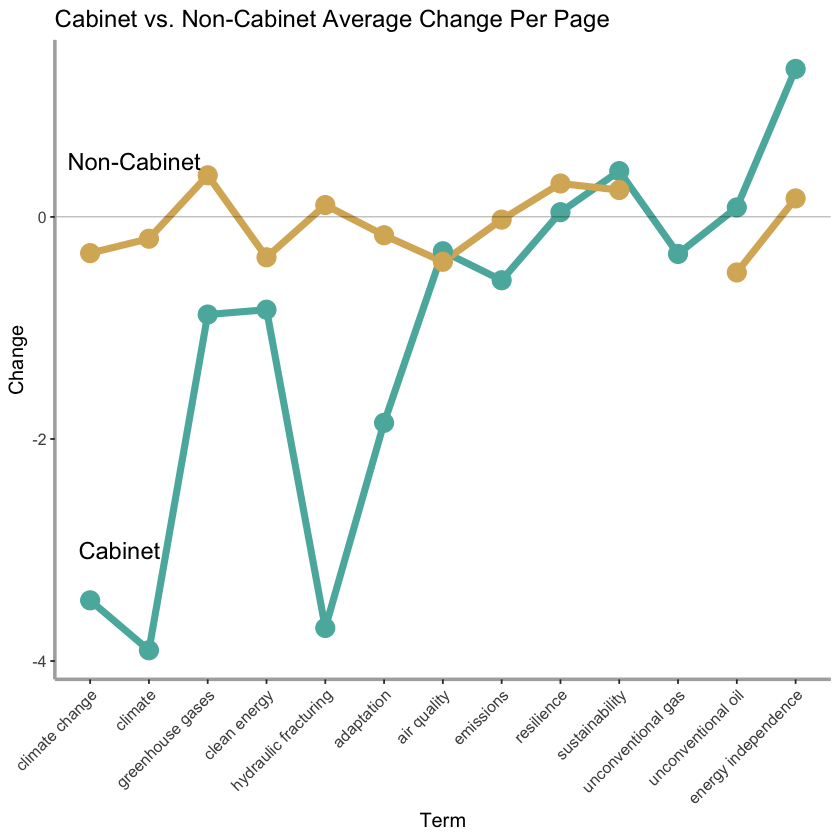

In [80]:
#FIGURE 7
#ideally the creation of cabinet_counts and cabinet_average would be done _in this script_

f<-read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/r/data/cabinet_average.csv")
f$Term<-factor(f$Term, levels=c("climate change", "climate", "greenhouse gases", "clean energy", 
                                "hydraulic fracturing", "adaptation", "air quality", "emissions", 
                                "resilience", "sustainability", "unconventional gas", "unconventional oil", 
                                "energy independence"))

p<-ggplot(data=f, aes(x=Term, y=Average, group=Cabinet)) +
  geom_line(aes(color=Cabinet), size=2)+
  geom_point(aes(color=Cabinet), size=5) + 
  geom_abline(intercept=0, slope=0, colour="black", size=.1) +
  theme(text=element_text(size=12), 
        axis.text.x = element_text(angle = 45, hjust = 1), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(), 
        legend.position="none",
        axis.line = element_line(colour = "grey68", size=1)) +
  labs(title="Cabinet vs. Non-Cabinet Average Change Per Page", y="Change") +
  scale_color_manual(values=c('#5ab4ac','#d8b365')) +
  annotate("text", label = "Cabinet", x = 1.5, y = -3, size = 5, colour = "black")  +
  annotate("text", label = "Non-Cabinet", x = 1.75, y = .5, size = 5, colour = "black")
p

Parsed with column specification:
cols(
  change = col_integer(),
  term = col_character(),
  cabinet = col_character()
)


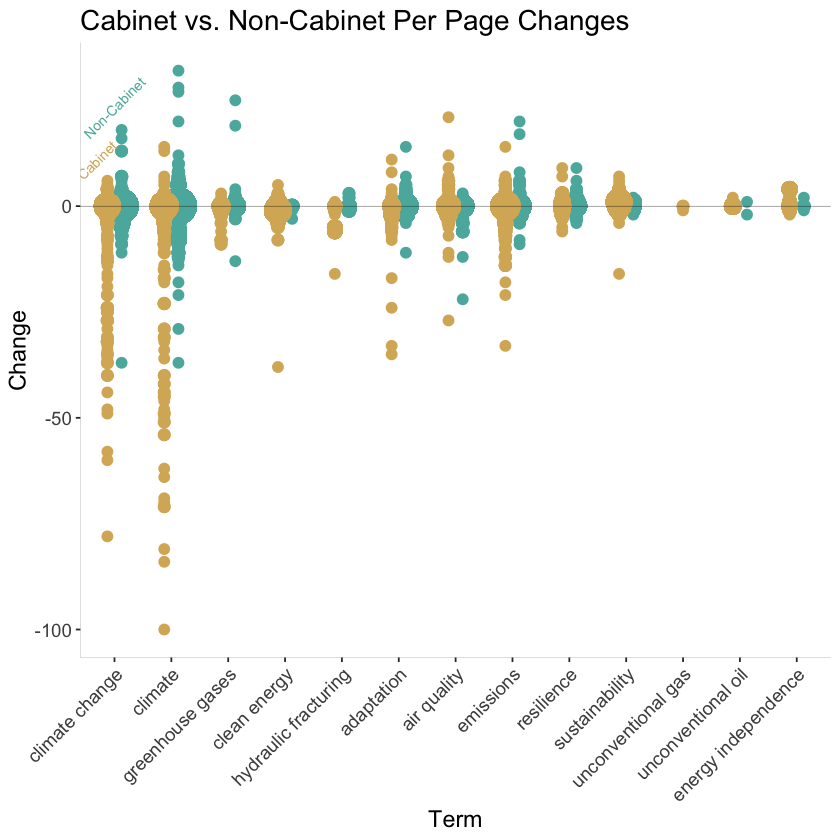

In [81]:
#FIGURE 8
#Ideally the creation of cabinet_counts and cabinet_average would be done _in this script_

f <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/r/data/cabinet_counts.csv")
f$term <- factor(f$term, levels=c("climate change", "climate", 
                                        "greenhouse gases", "clean energy", "hydraulic fracturing", 
                                        "adaptation", "air quality", "emissions", "resilience", "sustainability", 
                                        "unconventional gas", "unconventional oil", "energy independence"))

#How many of each change 1->2, 1->4, 3->1 are there?
f <- f %>% group_by(term, change, cabinet)%>%mutate(count=n())

p <- ggplot(f, aes(x=term, y=change)) +
  geom_point(aes(shape="20", color=cabinet, size=count), na.rm=TRUE, position=position_dodge(.5))+
  scale_size(range = c(3, 10)) +
  geom_abline(intercept=0, slope=0, colour="black", size=.1) +
  theme(text=element_text(size=14), axis.text.x = element_text(angle = 45, hjust = 1),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          legend.position="none", 
          axis.line = element_line(colour = "grey68", size=.1)) +
  labs(title="Cabinet vs. Non-Cabinet Per Page Changes", y="Change", x="Term") +
  scale_color_manual(values=c('#d8b365','#5ab4ac')) +
  annotate("text", angle = 45, hjust=1, label = "Cabinet", x = 1, y = 15, size = 3, colour = "#d8b365")  +
  annotate("text", angle = 45, hjust=1, label = "Non-Cabinet", x = 1.5, y = 30, size = 3, colour = '#5ab4ac')
p

Parsed with column specification:
cols(
  Term = col_character(),
  Visibility = col_character(),
  Percent = col_double(),
  Viz = col_double()
)


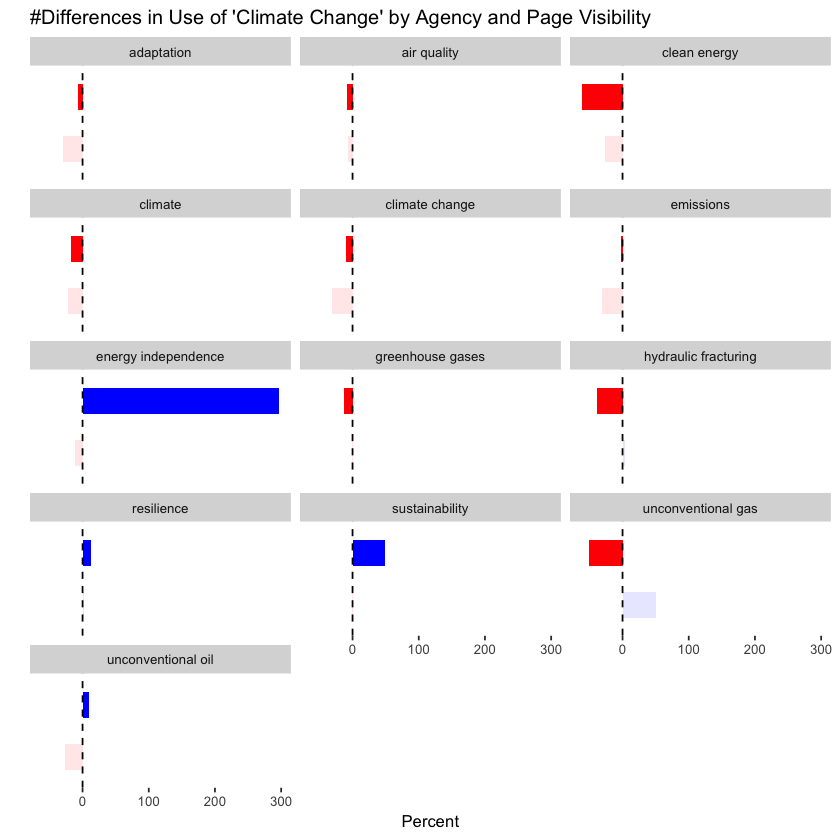

In [82]:
#FIGURE 9
#Depth analysis results were previously obtained by modifiying pages.length variable in "PROCESSING"
depth <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/r/data/depthR.csv")

colnames(depth)<-c("Term", "Visibility", "Percent", "Viz")

depth <- depth[order(-depth$Percent),]

pal <- c("red", "blue")

ggplot(depth, aes(x=Visibility, y=Percent, alpha=Viz, fill = Percent>0)) + 
  geom_bar(position="dodge", stat="identity", width = .5) +
  scale_fill_manual(values = pal) +
  geom_hline(yintercept=0, size=.5, linetype="dashed") +
  ggtitle("#Differences in Use of 'Climate Change' by Agency and Page Visibility") + 
  facet_wrap(~Term, ncol=3) +
  coord_flip() +
  xlab("") +  
  scale_x_discrete(breaks=NULL, labels=NULL)+
  theme(text=element_text(size=10),panel.background = element_rect(fill='white'), 
        legend.position="none", axis.text.y=element_blank(), panel.grid.major.y = element_blank(), 
        panel.grid.minor.y=element_blank(), panel.grid.minor.x=element_blank(), panel.grid.major.x=element_blank()) 

Parsed with column specification:
cols(
  Agency = col_character(),
  Visibility = col_character(),
  Percent = col_double(),
  Viz = col_double()
)


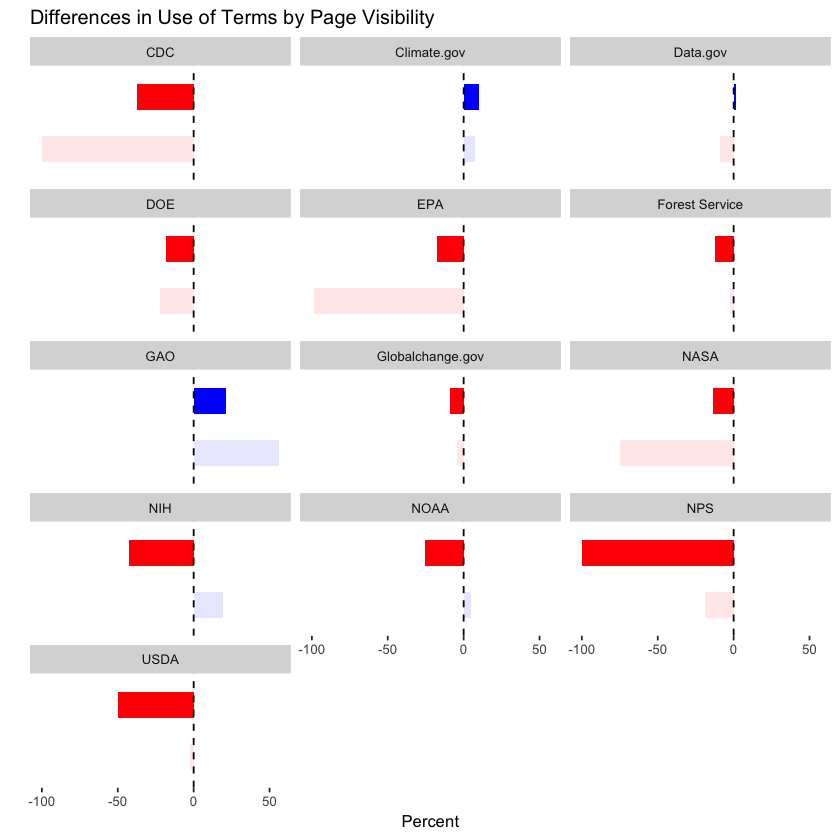

In [83]:
#FIGURE 10
#Depth analysis results were previously obtained by modifiying pages.length variable in "PROCESSING"
depth.agency <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/r/data/depthAgencyR.csv") 

colnames(depth.agency)<-c("Agency", "Visibility", "Percent", "Viz") 

depth.agency <- depth.agency[order(-depth.agency$Percent),]

pal <- c("red", "blue")

ggplot(depth.agency, aes(x=Visibility, y=Percent, alpha=Viz, fill = Percent>0)) + 
  geom_bar(position="dodge", stat="identity", width = .5) +
  scale_fill_manual(values = pal) +
  geom_hline(yintercept=0, size=.5, linetype="dashed") +
  ggtitle("Differences in Use of Terms by Page Visibility") + 
  facet_wrap(~Agency, ncol=3) + 
  coord_flip() +
  xlab("") +  
  scale_x_discrete(breaks=NULL, labels=NULL)+
  theme(text=element_text(size=10),panel.background = element_rect(fill='white'), 
        legend.position="none", axis.text.y=element_blank(), panel.grid.major.y = element_blank(), 
        panel.grid.minor.y=element_blank(), panel.grid.minor.x=element_blank(), panel.grid.major.x=element_blank()) 